In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:

#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.data.make_dataset import *
from src.data.modal_data import *

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

import shap

shap.initjs()

In [50]:
loc = 'nw2'
turbine = 'c02'
mode = 'whirling'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
selected_data= pd.read_parquet(os.path.join(data_folder, 'processed','nw2',mode, turbine+'_' + mode + '_selected_data.parquet'))

from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, loc, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

from src.data.make_dataset import create_input_data
mpe_ss_data = get_mpe_data(data['turbine_data'], 'SS', loc, turbine)

X = create_input_data(data_folder, loc, turbine)
X = X[selected_columns].loc[:datetime.datetime(2023, 6, 1, tzinfo=datetime.timezone.utc)]
y_train = selected_data['mean_frequency']

common_indices = X.dropna().index.intersection(y_train.dropna().index)
y_train = y_train.loc[common_indices]
X_train = pd.DataFrame(index = y_train.index)
for column in selected_columns:
    X_train[column] = X[column].loc[common_indices]

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


In [51]:
import pickle

models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder, turbine, mode, '_'.join([loc, turbine, mode, 'catboost_model.pkl']))
with open(model_path, 'rb') as file:
    regr_model = pickle.load(file)

In [54]:
regr_model.virtual_ensembles_predict(prediction_type='TotalUncertainty')


array([[6.85525872e-01, 4.83464555e-06, 2.45982203e+09],
       [6.58357628e-01, 2.56193335e-07, 1.52381878e-05],
       [6.58884296e-01, 4.70417059e-07, 2.01014014e-05],
       ...,
       [6.35331149e-01, 4.38061452e-07, 3.13838087e-05],
       [6.33115736e-01, 5.07751372e-07, 3.31199698e-05],
       [6.27915908e-01, 6.53793475e-07, 1.06721790e-06]])

In [55]:
regr_model.predict(X)

array([[6.79965759e-01, 2.30841422e+10],
       [6.58998614e-01, 1.25328315e-05],
       [6.59705004e-01, 1.93957851e-05],
       ...,
       [6.35274506e-01, 3.40296166e-05],
       [6.33153131e-01, 3.87779792e-05],
       [6.28937648e-01, 1.91349276e-06]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


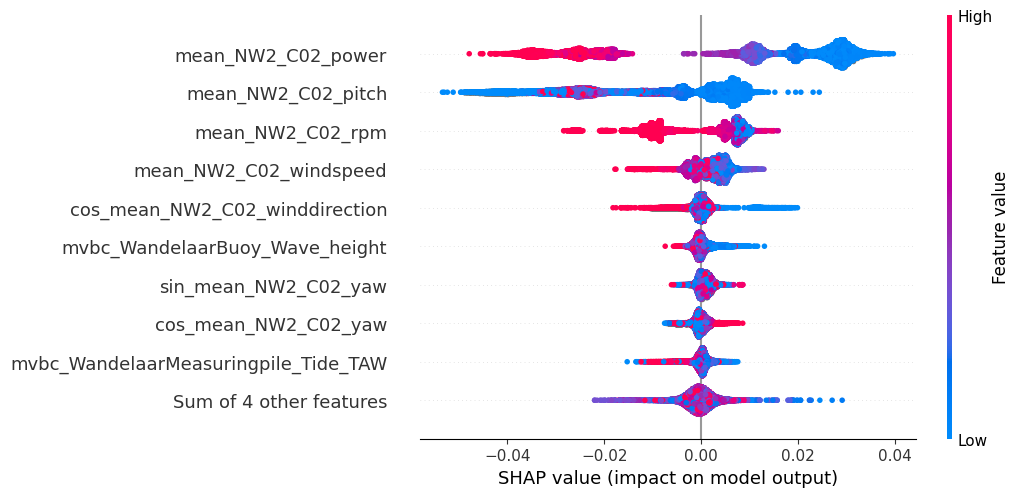

In [52]:
import shap

# Assuming regr_model is your trained multi-output model
# and X is your dataset
explainer = shap.TreeExplainer(regr_model)
shap_values = explainer.shap_values(X)

# Get SHAP values for the first output
first_output_shap_values = shap_values[0]

# Create an Explanation object from the SHAP values
# and the feature names (if available)
expl = shap.Explanation(values=first_output_shap_values, data=X)

# Now visualize the SHAP values for the first output
shap.plots.beeswarm(expl)


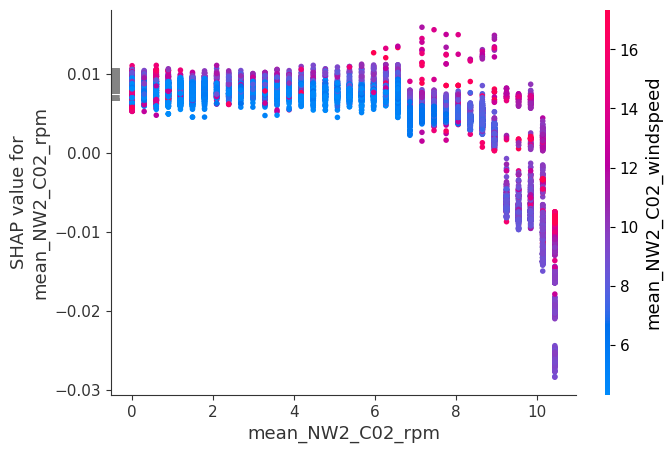

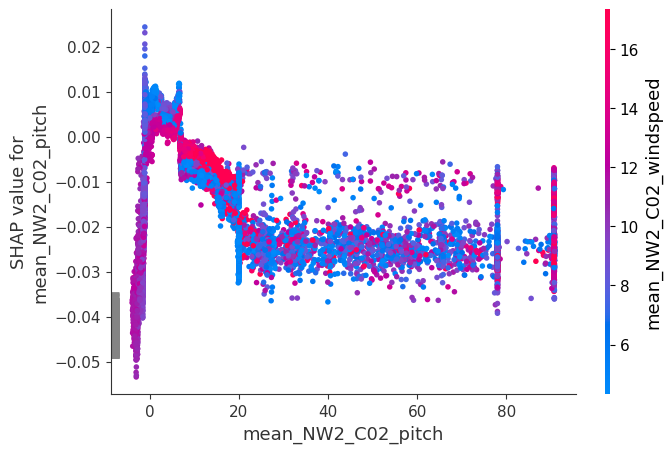

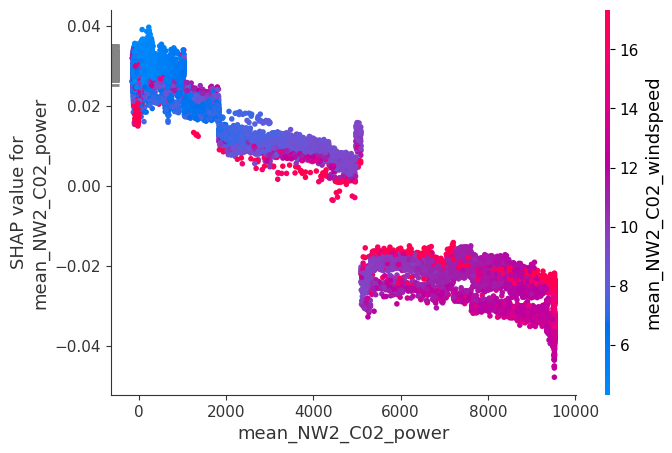

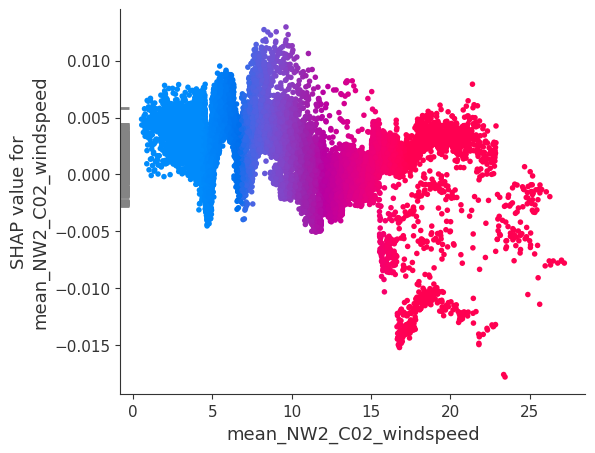

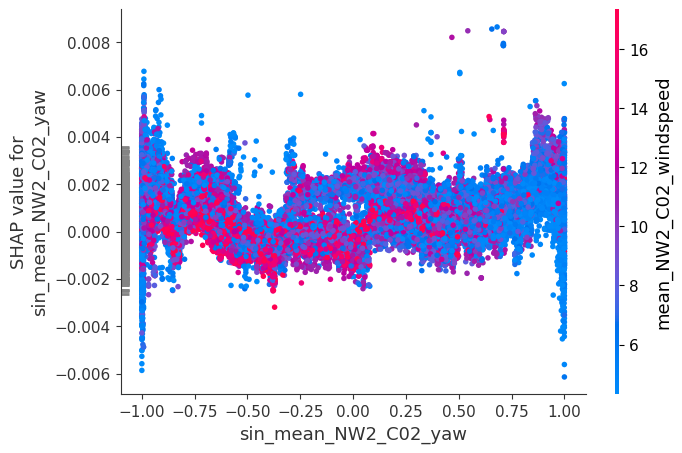

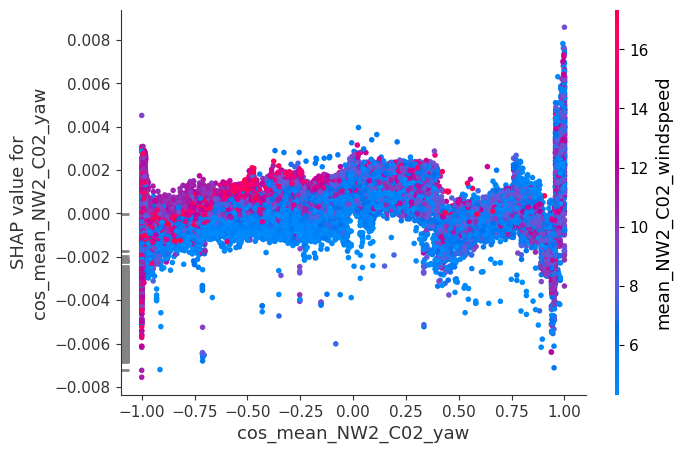

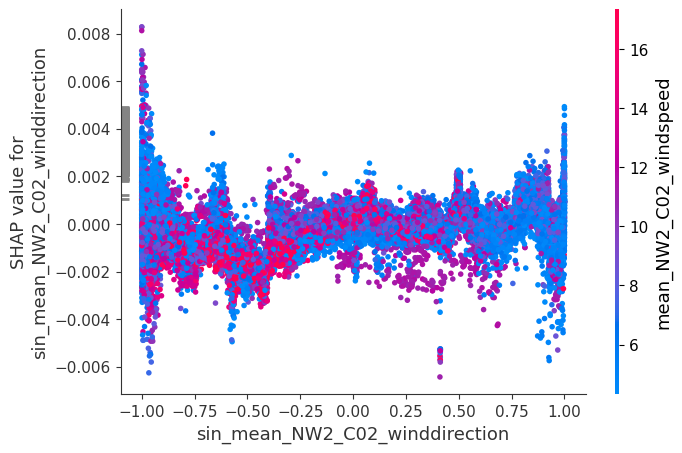

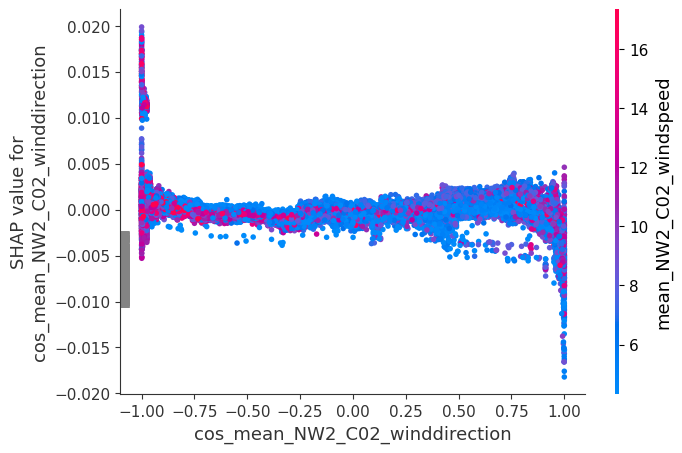

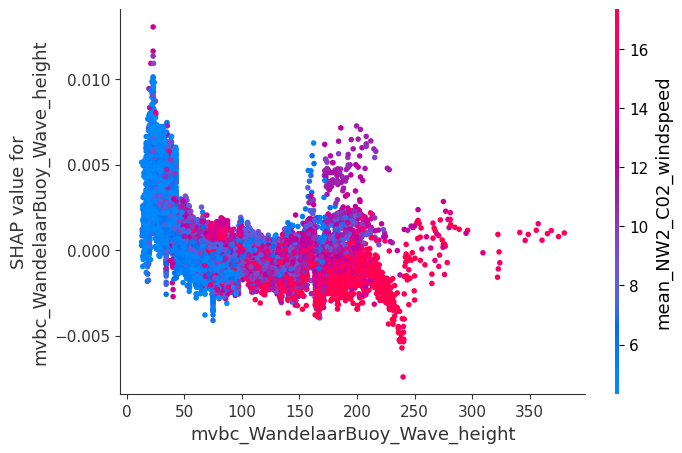

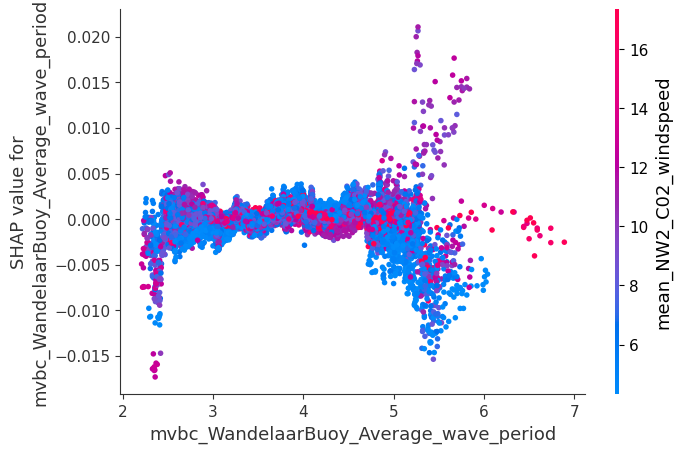

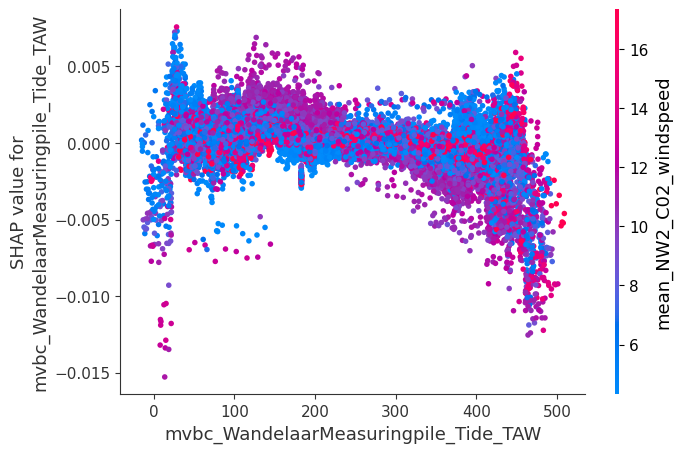

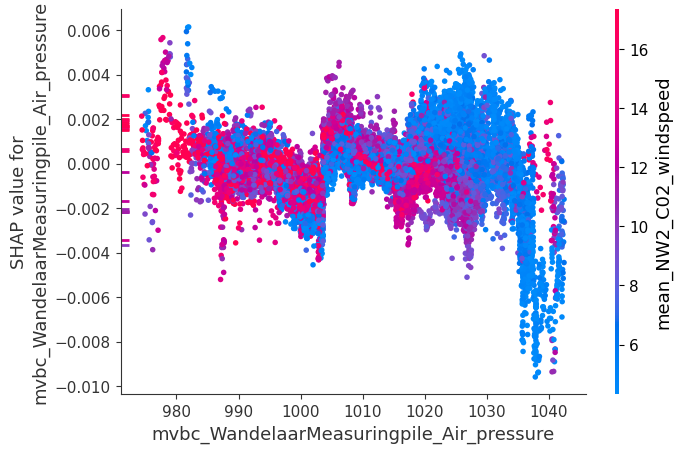

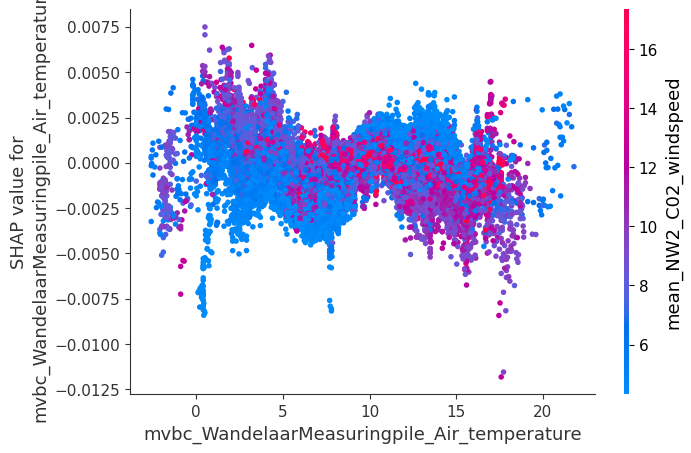

In [72]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
for col in X.columns:
    shap.dependence_plot(col, first_output_shap_values, X, interaction_index="mean_NW2_C02_windspeed")

In [69]:
explainer = shap.Explainer(regr_model.virtual_ensembles_predict, X)

In [70]:
shap_values = explainer(X)

Permutation explainer: 34969it [23:26:25,  2.41s/it]                                    


In [92]:
def custom_predict_function(X):
    return regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty')

In [93]:
explainer_virtual = shap.Explainer(custom_predict_function, X)
shap_values_virtual = explainer_virtual(X)

Permutation explainer:  91%|█████████ | 31770/34968 [5:19:59<38:14,  1.39it/s]    

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


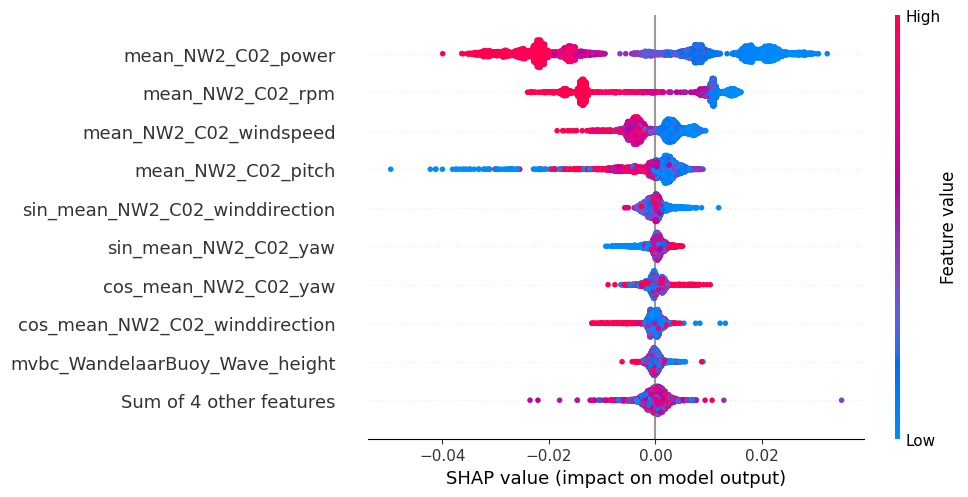

In [ ]:
knowledge_uncertainty_shap = shap_values_virtual[:,:,1]
# and the feature names (if available)
explanations_ = shap.Explanation(values=knowledge_uncertainty_shap, data=X)

# Now visualize the SHAP values for the first output
shap.plots.beeswarm(explanations_)

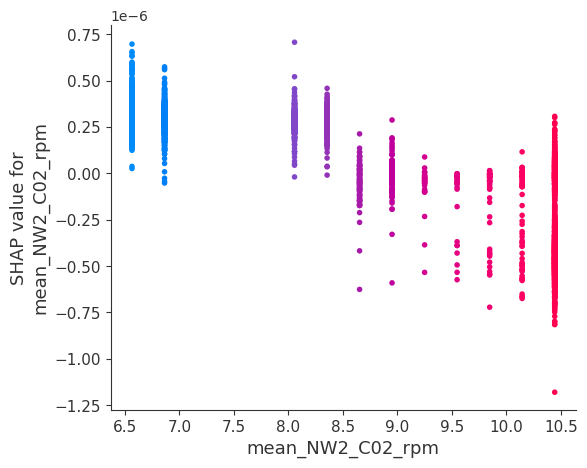

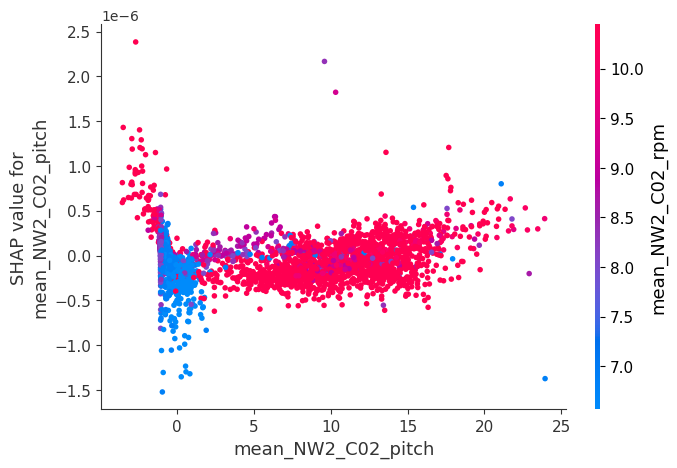

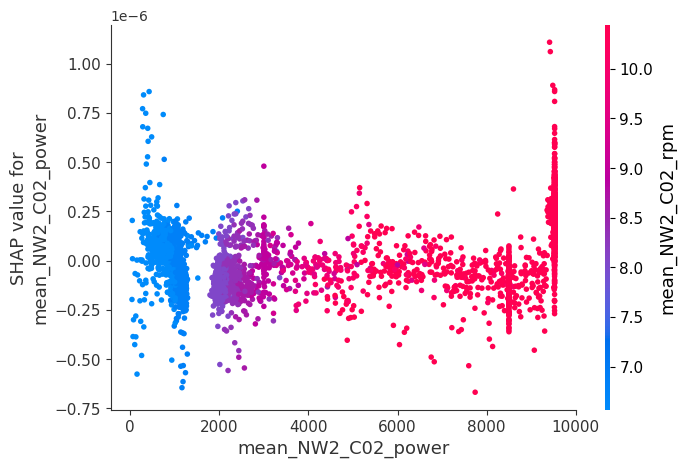

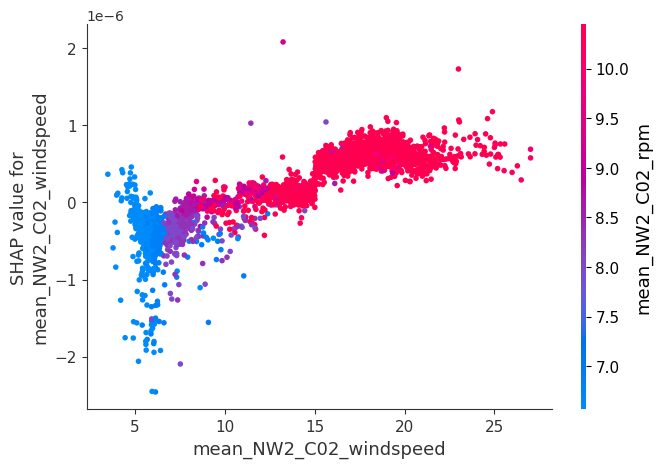

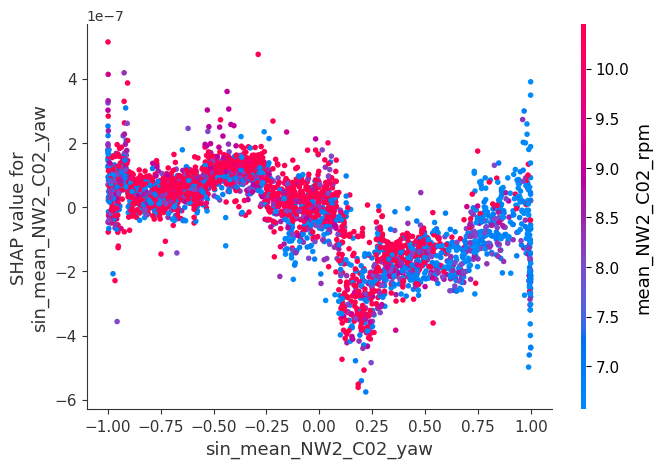

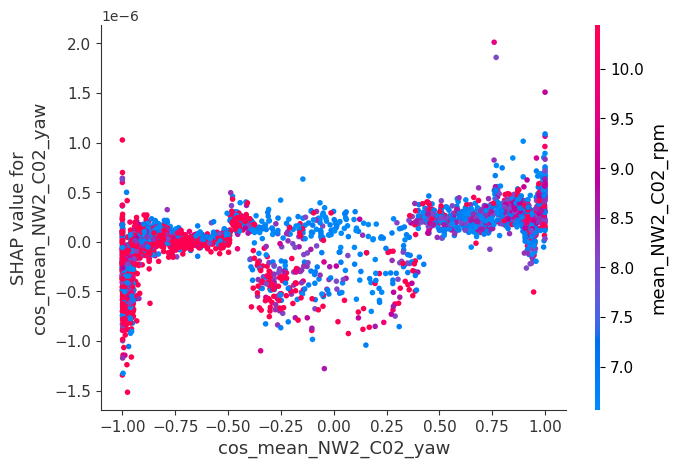

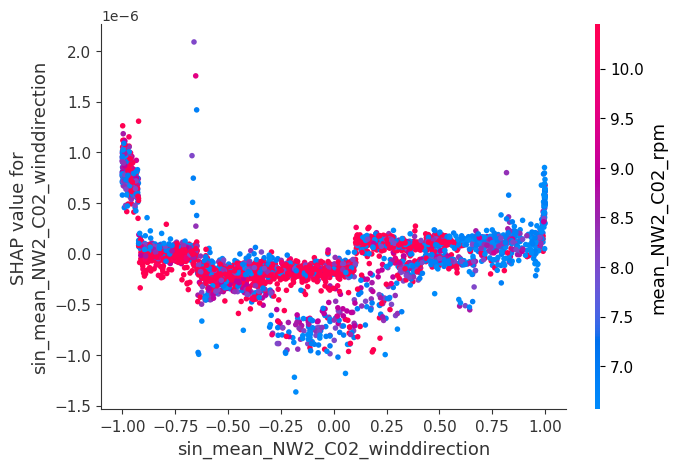

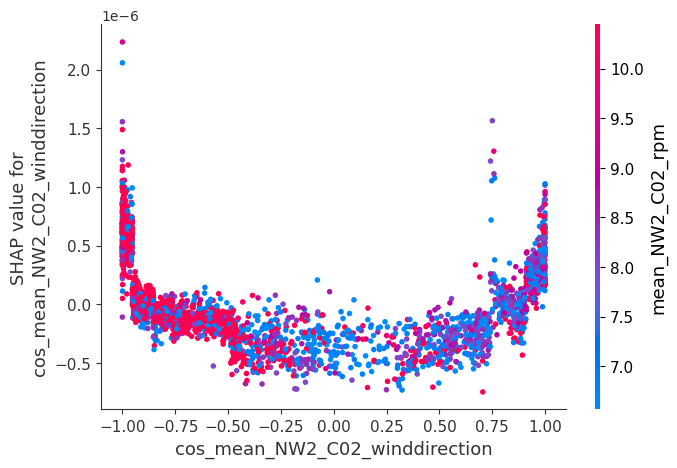

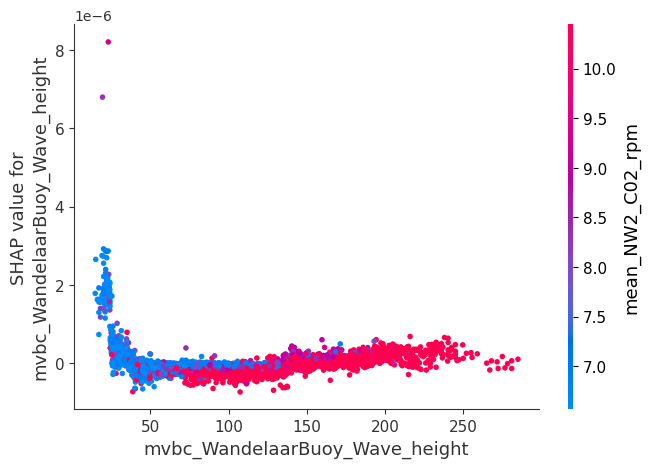

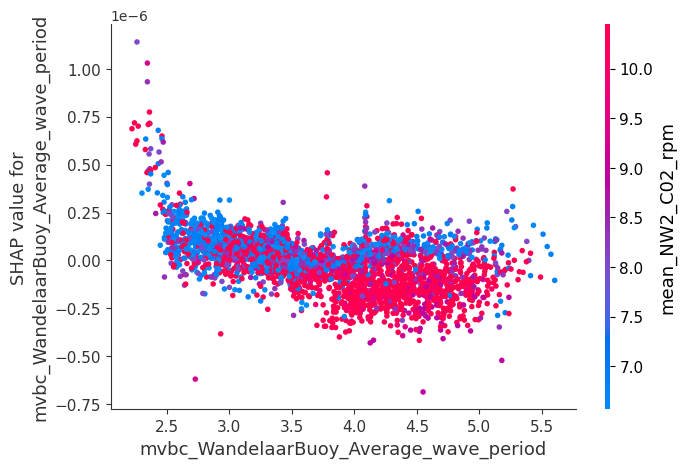

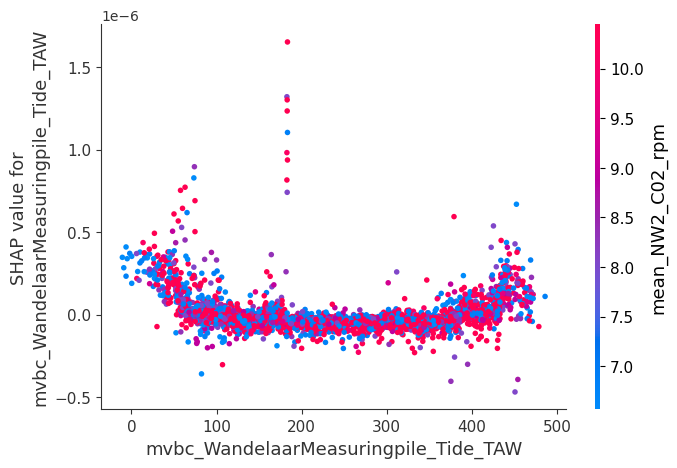

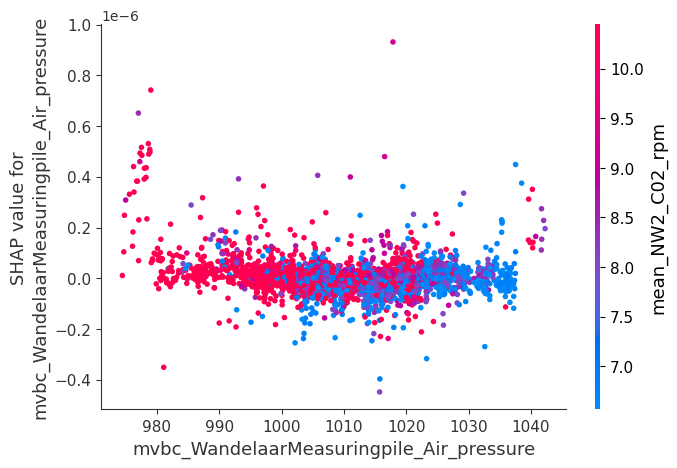

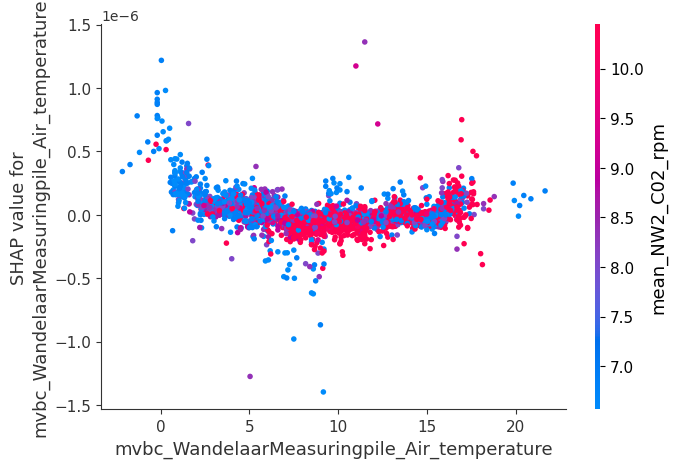

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
for col in X.columns:
    shap.dependence_plot(col, knowledge_uncertainty_shap, X, interaction_index="mean_NW2_C02_rpm")